In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from ordered_set import OrderedSet
from collections import OrderedDict
from datetime import datetime, timedelta

## Load the data

In [2]:
data_path = './Group_Data/Group_7.xlsx'
flight_data = pd.read_excel(data_path, sheet_name='Flight', parse_dates=['Departure', 'Arrival'])
num_flight = flight_data.shape[0]
flight_data.shape, flight_data.columns

((232, 10),
 Index(['Flight Number', 'ORG', 'DEST', 'Departure', 'Arrival', 'A330', 'A340',
        'B737', 'B738', 'BUS'],
       dtype='object'))

In [3]:
itinerary_data = pd.read_excel(data_path, sheet_name='Itinerary')
num_itinerary = itinerary_data.shape[0]
itinerary_data.shape, itinerary_data.columns

((780, 8),
 Index(['Itin No.', 'Origin', 'Destination', 'Demand', 'Fare', 'Stops', 'Leg 1',
        'Leg 2'],
       dtype='object'))

In [4]:
recaptureRate_data = pd.read_excel(data_path, sheet_name='Recapture Rate')
num_recaptureRate = recaptureRate_data.shape[0]
recaptureRate_data.shape, recaptureRate_data.columns

((327, 3),
 Index(['From Itinerary', 'To Itinerary', 'Recapture Rate'], dtype='object'))

In [5]:
aircraft_data = pd.read_excel(data_path, sheet_name='Aircraft')
num_ac_type = aircraft_data.shape[0] - 1
num_type = aircraft_data.shape[0]
aircraft_data.shape, aircraft_data.columns

((5, 4), Index(['Type', 'Units', 'Seats', 'TAT'], dtype='object'))

## Preprocess the data into Python objects

### Create `Flight` objects

In [6]:
# define the class of Flight
class Flight:
    '''
    Define the class of flight:
    refers to your airline’s daily flight schedule, which
    contains, for each flight in the schedule, the flight number, the
    departure and arrival times, and operating costs for each aircraft
    type (in €).
    '''
    def __init__(self, 
        flight_number: str,
        origin: str,
        destin: str,
        departureTime, # datetime
        arrivalTime,   # datetime
        costs: dict
        ):
        self.flightNo = None
        self.flight_number = flight_number
        self.origin = origin
        self.destin = destin
        self.departureTime = departureTime
        self.arrivalTime = arrivalTime
        self.costs = costs
        
    def setNo(self, no):
        self.flightNo = no
        
    def __repr__(self,):
        return self.flight_number + ':' + self.origin + '->' + self.destin
    
    def __str__(self,):
        return self.__repr__()
    
# construct the set of flights
flightSet = []
for flight in range(num_flight):
    flight_number = flight_data['Flight Number'][flight]
    origin = flight_data['ORG'][flight]
    destin = flight_data['DEST'][flight]
    departureTime = flight_data['Departure'][flight]
    arrivalTime = flight_data['Arrival'][flight]
    costs = {
            'A330':  flight_data['A330'][flight],
            'A340':  flight_data['A340'][flight],
            'B737':  flight_data['B737'][flight],
            'B738':  flight_data['B738'][flight],
            'BUS':  flight_data['BUS'][flight],
        }
    
    f = Flight(
            flight_number = flight_number,
            origin = origin,
            destin = destin,
            departureTime = departureTime,
            arrivalTime = arrivalTime,
            costs = costs,
        )
    f.setNo(flight)
    flightSet.append(f)
    
assert len(flightSet) == num_flight
num_flight

232

### Create `Itinerary` objects

In [7]:
# define the class of Itinerary
class Itinerary:
    '''
    Define the class of itinerary:
    passenger itineraries, indicating the origin and destination, the demand and the fare (in
    €) for each itinerary. In addition, the flight or pair of flights used in each itinerary is provided
    '''
    def __init__(
        self,
        no: int,
        origin: str,
        destin: str,
        demand: int,
        fare: int,
        num_stops: int,
        leg1,
        leg2,
    ):
        self.no = no,
        self.origin = origin,
        self.destin = destin,
        self.demand = demand,
        self.fare = fare,
        self.num_stops = num_stops,
        self.leg1 = leg1,
        self.leg2 = leg2

# construct the set of itineraries
itinerarySet = []
for itinerary in range(num_itinerary):
    no = itinerary_data['Itin No.'][itinerary]
    origin = itinerary_data['Origin'][itinerary]
    destin = itinerary_data['Destination'][itinerary]
    demand = int(itinerary_data['Demand'][itinerary])
    fare = int(itinerary_data['Fare'][itinerary])
    num_stops = itinerary_data['Stops'][itinerary]
    leg1 = itinerary_data['Leg 1'][itinerary]
    leg2 = itinerary_data['Leg 2'][itinerary]
    itinerarySet.append(
        Itinerary(
            no=no,
            origin=origin,
            destin=destin,
            demand=demand,
            fare=fare,
            num_stops=num_stops,
            leg1=leg1,
            leg2=None if leg2 == 0 else leg2
        )
    )

# append the fictitious itinerary
itinerarySet.append(
    Itinerary(
        no = -1,
        origin=None,
        destin=None,
        demand=0,
        fare=0,
        num_stops=0,
        leg1=None,
        leg2=None
    )
)
    
assert len(itinerarySet) == num_itinerary + 1
num_itinerary

780

### Create `Recapture Rate` set 

In [8]:
# construct the mappings between itinerary<From, To> and recapture rate
recaptureRateSet = {}

for i in itinerarySet:
    for j in itinerarySet:
        recaptureRateSet[i.no[0], j.no[0]] = 0

for idx in range(num_recaptureRate):
    # loop through all the recapture rates
    fromIti = recaptureRate_data['From Itinerary'].iloc[idx]
    toIti = recaptureRate_data['To Itinerary'].iloc[idx]
    recaptureRateSet[fromIti, toIti] = recaptureRate_data['Recapture Rate'].iloc[idx]

assert len(recaptureRateSet) == (num_itinerary+1)**2

### Read `aircraft` parameters

In [9]:
# retrieve the infos about aircraft types, units, seats and TATs
aircraftNames = ['A330', 'A340', 'B737', 'B738', 'BUS']
units = aircraft_data['Units']
seats = aircraft_data['Seats']
TATs = aircraft_data['TAT']

### Create `Node` objects

In [10]:
class Node:
    '''
    Based on the time-space network, 
    a node is the position that aircraft departs or arrives at airport i in the time t.
    '''
    def __init__(
        self,
        airport,
        timestamp,
    ):
        self.airport = airport
        self.timestamp = timestamp
        self.num_airports_in = 1
        self.num_airports_out = 1
        self.nodeNo = None
        
    def setNodeNo(self, no):
        self.nodeNo = no
        
    def __repr__(self):
        return self.airport+': '+str(self.timestamp)+' '+str(self.nodeNo)
    
    def __str__(self):
        return self.__repr__()

    def __key(self):
        return (self.airport, self.timestamp)

    def __hash__(self):
        return hash(self.__key())

    def __eq__(self, other):
        if isinstance(other, Node):
            return self.__key() == other.__key()
        return NotImplemented        

# construct the set of Nodes
nodeSet = OrderedSet()
no = 0
for flight in flightSet:
    # create the node where an flight departs
    node = Node(airport=flight.origin, timestamp=flight.departureTime)
    if node not in nodeSet:
        node.setNodeNo(no)
        no += 1
        nodeSet.add(node)
    else:
        loc = nodeSet.get_loc(node)
        nodeSet[loc].num_airports_out += 1
    # create the node where an flight arrives
    node = Node(airport=flight.destin, timestamp=flight.arrivalTime)
    if node not in nodeSet:
        node.setNodeNo(no)
        no += 1
        nodeSet.add(node)
    else:
        loc = nodeSet.get_loc(node)
        nodeSet[loc].num_airports_in += 1
len(nodeSet)

422

### Create `Ground` objects

In [11]:
class Ground:
    def __init__(
        self,
        airport,
        begin_timestamp,
        end_timestamp,
        begin_node,
        end_node,
        isOvernight = False
    ):
        self.airport = airport
        self.begin_timestamp = begin_timestamp
        self.end_timestamp = end_timestamp
        self.beginNode = begin_node
        self.endNode = end_node
        self.groundNo = None
        self.isOvernight = isOvernight
        
    def setGroundNo(self, no):
        self.groundNo = no
        
    def __repr__(self,):
        return str(self.beginNode) + ' > ' + str(self.endNode)
    
    def __str__(self,):
        return self.__repr__()

In [12]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x.timestamp - pivot.timestamp))

def earlyest(items, pivot):
    return max(items, key=lambda x: abs(x.timestamp - pivot.timestamp))

# construct the set of Grounds
groundSet = OrderedSet()
no = 0

for idx, node_1 in enumerate(nodeSet):
    afterNodes = []
    potentialNodes = []
    for node_2 in nodeSet:
        if node_1.nodeNo == node_2.nodeNo:
            continue 
        elif node_1.airport == node_2.airport:
            potentialNodes.append(node_2) # append all the nodes in the same airport into the potentialNode list.
            if node_2.timestamp > node_1.timestamp:
                afterNodes.append(node_2)     # append all the nodes that are in the same airport and after the current node.
        
    # search for the closest datatime of the current node to create a ground object
    if len(afterNodes) > 0:
        node = nearest(afterNodes, pivot=node_1)
        ground = Ground(node_1.airport, node_1.timestamp, node.timestamp, node_1, node, False)
        ground.setGroundNo(no)
        groundSet.add(ground)
        no += 1
        
    # indicates that this is an overnight ground arc
    if len(afterNodes) == 0:
        node = earlyest(potentialNodes, pivot=node_1)
        ground = Ground(node_1.airport, node_1.timestamp, node.timestamp + timedelta(days=1), node_1, node, True)
        ground.setGroundNo(no)
        groundSet.add(ground)
        no += 1

assert len(groundSet) == no
num_ground = len(groundSet)
num_ground

422

### $NG^k$

In [13]:
num_slot = 24

ng_k = OrderedDict()
# initialize 
for slot in range(num_slot):
    ng_k[slot] = {'ground':[], 'flight':[]}
# add the time slots

year, month, day = datetime.now().year, datetime.now().month, datetime.now().day
print(datetime.now())

for slot in range(num_slot):
    timeslot = datetime(year,month,day,slot,30,0)
    # print(timeslot)
    # select the flight that covers the time slot
    for fdx, flight in enumerate(flightSet):
        departureTime = flight.departureTime
        arrivalTime = flight.arrivalTime
        if departureTime <= timeslot < arrivalTime: 
            ng_k[slot]['flight'].append(flight)
        
# select the ground that covers the time slot
    for gdx, ground in enumerate(groundSet):
        begin = ground.begin_timestamp
        end = ground.end_timestamp
        if begin <= timeslot < end:
            ng_k[slot]['ground'].append(ground)
            
assert len(ng_k) == num_slot

2023-01-05 14:41:34.367961


### $O(k,n)$ and $I(k,n)$

In [14]:
# O(k, n): flight arcs originating at node n in fleet k
# I(k, n): flight arcs terminating at node n in fleet k

O_kn = OrderedDict()
I_kn = OrderedDict()

# initialize
for ac in range(num_type):
    for ndx, node in enumerate(nodeSet):
        O_kn[ac, ndx] = []
        I_kn[ac, ndx] = []
# append the NO.s
for ac in range(num_type): # loop through 5 types of aircrafts and bus
    for ndx, node in enumerate(nodeSet):   # loop through all the nodes
        airport = node.airport
        for fdx, flight in enumerate(flightSet):
            if flight.origin == airport:   # if this flight originates at node n 
                O_kn[ac, ndx].append(fdx)
            if flight.destin == airport:   # if this flight terminates at node n
                I_kn[ac, ndx].append(fdx)

### $n^+$ and $n^-$

In [15]:
# n+: ground arcs originating at any node n
# n-: ground arcs terminating at any node n

n_plus = OrderedDict()
n_minus = OrderedDict()

# initialize
for ndx, node in enumerate(nodeSet):
    n_plus[ndx] = []
    n_minus[ndx] = []
# append the NO.s
for ndx, node in enumerate(nodeSet):
    airport = node.airport
    for gdx, ground in enumerate(groundSet):
        if ground.beginNode.nodeNo == node.nodeNo: # if this ground arcs originates at the node n
            n_plus[ndx].append(gdx)
        if ground.endNode.nodeNo == node.nodeNo:   # if this ground arcs terminates at the node n
            n_minus[ndx].append(gdx)
            
for ndx, node in enumerate(nodeSet):
    assert len(n_plus[ndx]) == 1
    assert len(n_minus[ndx]) == 1

### $\delta_i^p$

In [16]:
delta = OrderedDict()

for fdx, flight in enumerate(flightSet):
    for idx, itinerary in enumerate(itinerarySet):
        if flight.flight_number == itinerary.leg1 or flight.flight_number == itinerary.leg2:
            delta[fdx, itinerary.no[0]] = 1
        else:
            delta[fdx, itinerary.no[0]] = 0
            
assert len(delta) == num_flight * (num_itinerary+1)

### $Q_i$

In [17]:
flight_demand = []

for fdx, flight in enumerate(flightSet):
    dmd = 0
    for idx, itinerary in enumerate(itinerarySet):
        dmd += delta[fdx, itinerary.no[0]] * itinerary.demand[0]
    flight_demand.append(dmd)
    
assert len(flight_demand) == num_flight

## $Cost_{k,i}$

In [18]:
costs = OrderedDict()

for fdx, flight in enumerate(flightSet):
    for idx, val in enumerate(flight.costs.values()):
        costs[fdx, idx] = val
        
assert len(costs) == num_type * num_flight

## Column Generation Algorithm (CG)

### Solve the initial RMP

#### Decision variables

In [19]:
# In the initial RMP, a 'fictitious' itinerary is considered as the buffer for spillage.
model = gp.Model('RMP')

# declare the decision variables
# f_i^k: binary variable if flight arc i is assigned to aircraft type k, otherwise 0 
# (assumed continous in RMF setting)
f = model.addVars(num_flight, num_type, lb=0, vtype=gp.GRB.CONTINUOUS)
assert len(f) == num_flight * num_type

# y_a^k: integer variable indicating the number of aircrafts of type k on the ground arc a 
# (assumed continous in RMF setting)
y = model.addVars(num_ground, num_type, lb=0, vtype=gp.GRB.CONTINUOUS)
assert len(y) == num_ground * num_type

# t_p^r: the number of passengers that would like to travel on itinerary p but are reallocated by the airline to itinerary r
num_initial = num_itinerary
COLUMNS = []
for itinerary in itinerarySet:
    if itinerary.no == (-1,):
        pass
    else:
        COLUMNS.append((itinerary.no[0], -1))

assert len(COLUMNS) == num_itinerary

t = OrderedDict()
for i in itinerarySet:
    for j in itinerarySet:
        t[i.no[0], j.no[0]] = 0
        
for pdx, rdx in COLUMNS:
    t[pdx, rdx] = model.addVar(lb=0, vtype=gp.GRB.CONTINUOUS, name=f't_{pdx}_{rdx}')
    
assert len(t) == (num_itinerary+1)**2

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-12


<!-- 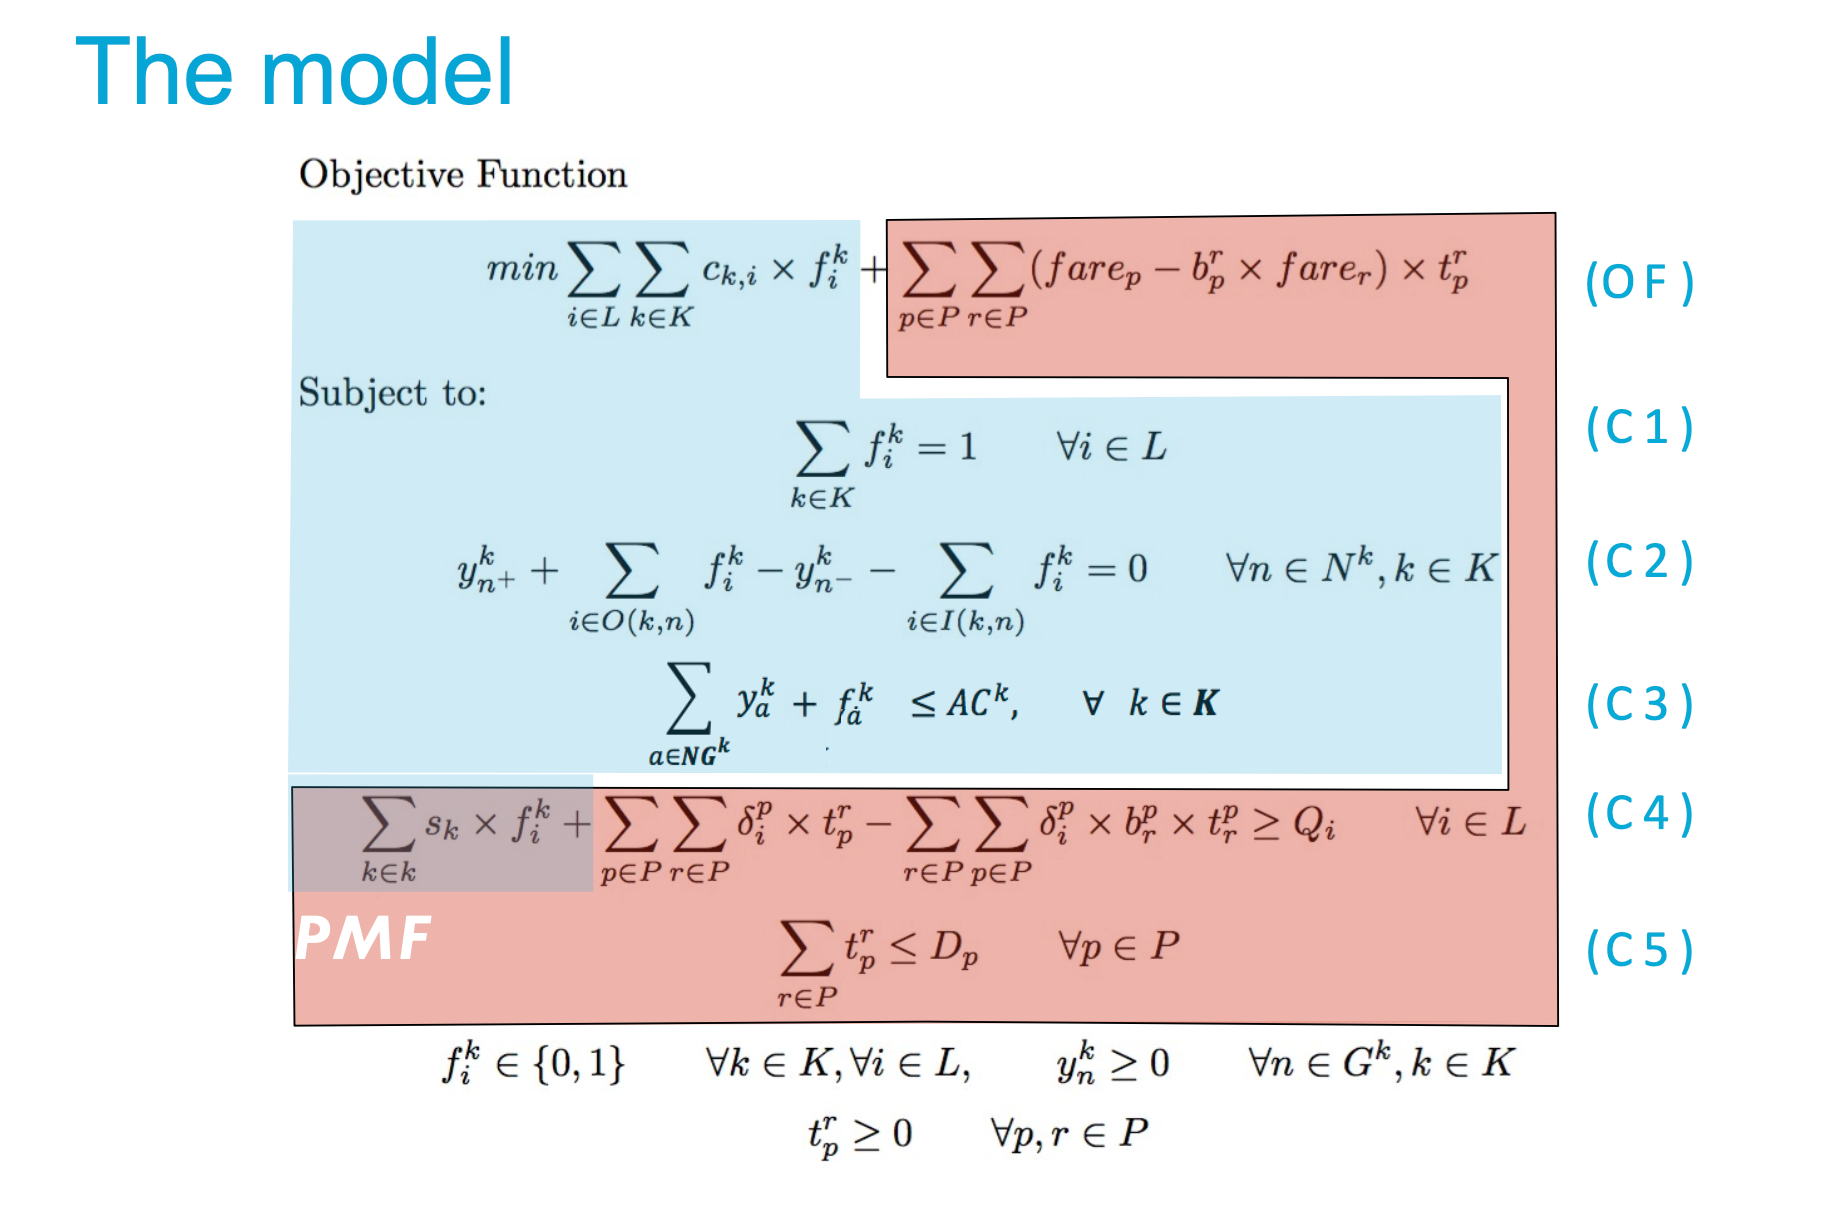 -->
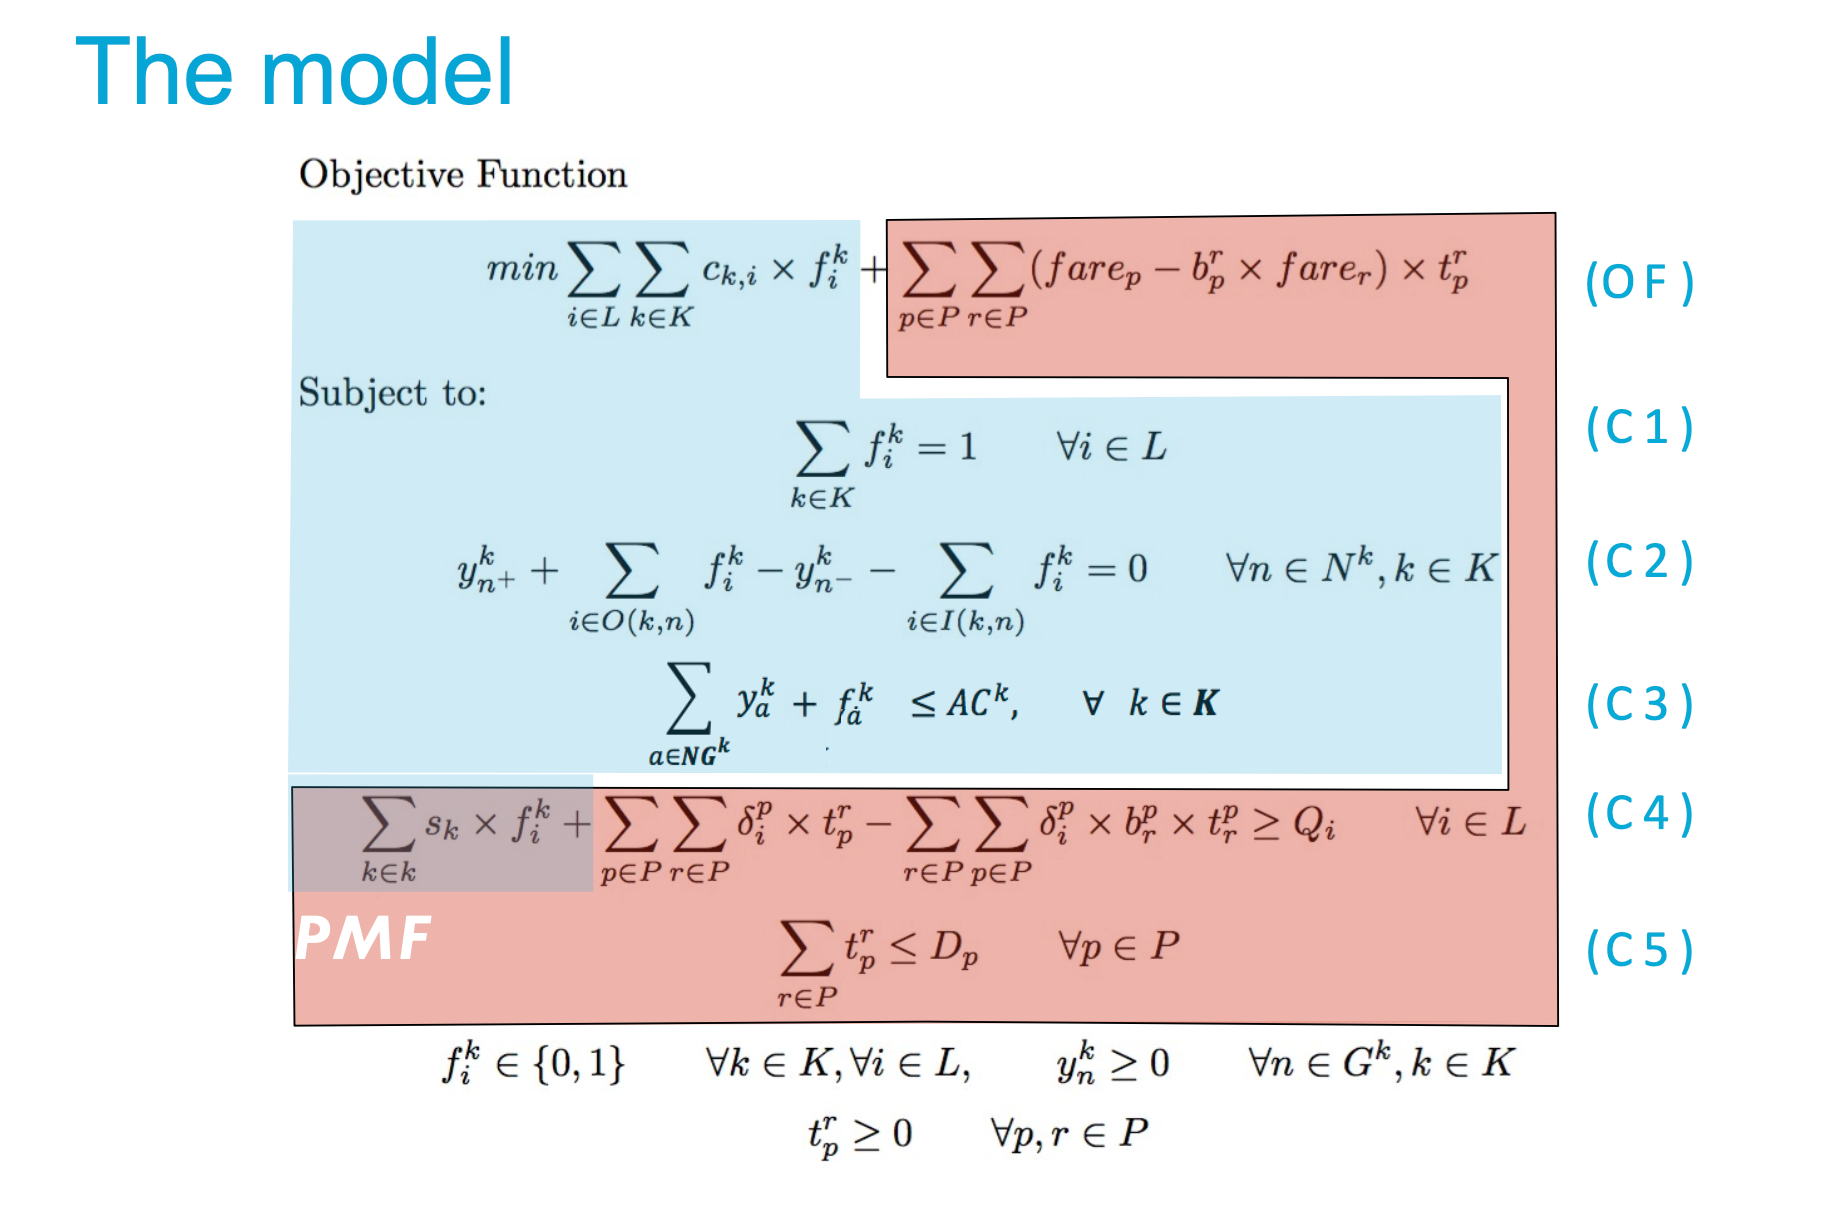

#### Constraints

In [20]:
# C1: Each flight covered exactly once by one fleet type
c1 = []
for fdx, flight in enumerate(flightSet):
    c1.append(
        model.addConstr(
            gp.quicksum(f[fdx, k] for k in range(num_type)) == 1
        ))
assert len(c1) == num_flight
print(len(c1), 'constraints in C1')
model.update()

232 constraints in C1


In [21]:
# C2: The number of AC arriving = the number of AC departing, for each type
c2 = OrderedDict()
for ac in range(num_type):
    for ndx, node in enumerate(nodeSet):
        gdx_out = groundSet[n_plus[ndx][0]].groundNo # n+
        gdx_in  = groundSet[n_minus[ndx][0]].groundNo # n-  
        flight_out = O_kn[ac, ndx] # out
        flight_in  = I_kn[ac, ndx] # in
        c2[ndx, ac] = model.addConstr(
            y[gdx_out, ac] - y[gdx_in, ac] + gp.quicksum(f[fdx, ac] for fdx in flight_out) - gp.quicksum(f[fdx, ac] for fdx in flight_in) == 0
        )
assert len(c2) == num_type * len(nodeSet)
print(len(c2), 'constraints in C2')
model.update()

2110 constraints in C2


In [22]:
# C3: Number of aircraft available
c3 = []
for slot in range(num_slot):
    for ac in range(num_type):
        c3.append(
            model.addConstr(
                gp.quicksum(f[flight.flightNo, ac] for flight in ng_k[slot]['flight']) + 
                gp.quicksum(y[ground.groundNo, ac] for ground in ng_k[slot]['ground']) <= units[ac]
        ))
assert len(c3) == num_type * num_slot
print(len(c3), 'constraints in C3')
model.update()

120 constraints in C3


In [23]:
# C4: Capacity
c4 = []
for fdx, flight in enumerate(flightSet):
    c4.append(
        model.addConstr(
            gp.quicksum(seats[ac]*f[fdx,ac] for ac in range(num_type)) + 
            gp.quicksum(delta[fdx,ppdx] * t[ppdx, rrdx] for ppdx, rrdx in COLUMNS) -
            gp.quicksum(delta[fdx,ppdx] * recaptureRateSet[rrdx,ppdx] * t[rrdx,ppdx] for ppdx, rrdx in COLUMNS)
            >= flight_demand[fdx]
        ))
assert len(c4) == num_flight
print(len(c4), 'constraints in C4')
model.update()

232 constraints in C4


In [24]:
  
# C5: Demands
c5 = []
for pdx in range(num_itinerary):
    c5.append(
        model.addConstr(
            gp.quicksum(t[ppdx, rrdx] for ppdx, rrdx in COLUMNS if ppdx == pdx) <= itinerarySet[pdx].demand[0]
    ))
assert len(c5) == num_itinerary
print(len(c5), 'constraints in C5')
model.update()

780 constraints in C5


#### Objective function

In [25]:
obj1 = gp.quicksum(costs[i,k]*f[i,k] for i in range(num_flight) for k in range(num_type))
obj2 = gp.quicksum(t[p.no[0],r.no[0]]*(p.fare[0]-recaptureRateSet[p.no[0], r.no[0]]*r.fare[0]) 
                        for p in itinerarySet for r in itinerarySet)
model.setObjective(
    obj1 + obj2
)
model.modelSense = gp.GRB.MAXIMIZE
model.update()
model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 3474 rows, 4050 columns and 172673 nonzeros
Model fingerprint: 0xc0d58d96
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [5e+01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 1050 rows and 780 columns
Presolve time: 0.06s
Presolved: 2424 rows, 3270 columns, 169928 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.765e+05
 Factor NZ  : 1.061e+06 (roughly 10 MB of memory)
 Factor Ops : 6.383e+08 (less than 1 second per iteration)
 Threads    : 6

Barrier performed 0 iterations in 0.14 seconds (0.13 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 1362 iterations and 0.14 seconds (0.32 

In [26]:
# for pdx, _ in COLUMNS:
#     for _, rdx in COLUMNS:
#         t_sol = t[pdx, rdx]
#         print(f"{t_sol.X:3.0f}", sep=' ')
    

## Dual variables

In [27]:
for c in c4:
    if c.Pi > 0:
        print(f"{c}: {c.Pi}")

In [28]:
for c in c5:
    # if c.Pi > 0:
    print(f"{c}: {c.Pi}")

<gurobi.Constr R2694>: 45.0
<gurobi.Constr R2695>: 97.0
<gurobi.Constr R2696>: 101.0
<gurobi.Constr R2697>: 81.0
<gurobi.Constr R2698>: 54.0
<gurobi.Constr R2699>: 54.0
<gurobi.Constr R2700>: 96.0
<gurobi.Constr R2701>: 83.0
<gurobi.Constr R2702>: 53.0
<gurobi.Constr R2703>: 51.0
<gurobi.Constr R2704>: 48.0
<gurobi.Constr R2705>: 106.0
<gurobi.Constr R2706>: 92.0
<gurobi.Constr R2707>: 106.0
<gurobi.Constr R2708>: 108.0
<gurobi.Constr R2709>: 99.0
<gurobi.Constr R2710>: 70.0
<gurobi.Constr R2711>: 106.0
<gurobi.Constr R2712>: 50.0
<gurobi.Constr R2713>: 101.0
<gurobi.Constr R2714>: 103.0
<gurobi.Constr R2715>: 100.0
<gurobi.Constr R2716>: 94.0
<gurobi.Constr R2717>: 104.0
<gurobi.Constr R2718>: 100.0
<gurobi.Constr R2719>: 99.0
<gurobi.Constr R2720>: 94.0
<gurobi.Constr R2721>: 48.0
<gurobi.Constr R2722>: 45.0
<gurobi.Constr R2723>: 54.0
<gurobi.Constr R2724>: 45.0
<gurobi.Constr R2725>: 108.0
<gurobi.Constr R2726>: 93.0
<gurobi.Constr R2727>: 93.0
<gurobi.Constr R2728>: 91.0
<gurobi.C

### Solve the relaxed IFAM problem

### Solve the relaxed IFAM problem with integer DVs